In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


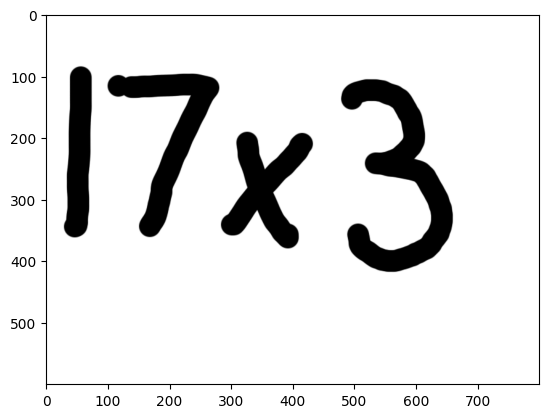

In [3]:
image = cv2.imread("/content/drive/MyDrive/eq/173.png")
plt.imshow(image)

In [4]:
# Grayscale
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

# thresholding
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 2)
thresh = cv2.convertScaleAbs(thresh)

# contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [5]:
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

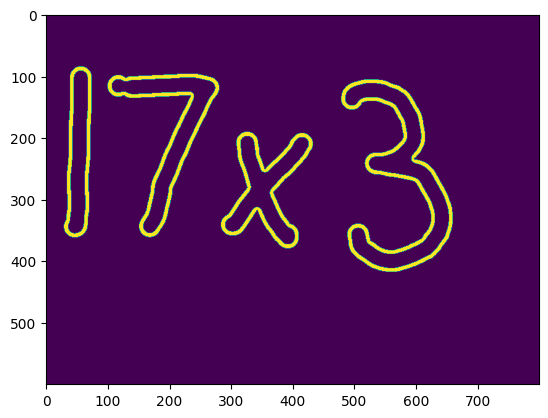

In [6]:
cv2_imshow(thresh)

In [7]:
contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

cropped_symbols = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    roi = image[y:y+h, x:x+w]
    cropped_symbols.append(roi)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
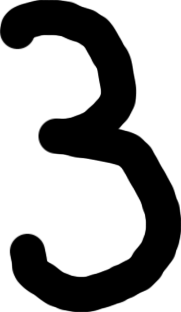

In [8]:
cropped_symbols[3]

In [9]:
def object_reader(image):
## INPUT: An image
## OUTPUT: List of cropped images with objects in it

  # Grayscale
  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

  # thresholding
  thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 2)
  thresh = cv2.convertScaleAbs(thresh)

  # contours
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

  cropped_symbols = []
  spacing = 15

  for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    # Add some spacing around the symbol so it is easier for model to understand
    x -= spacing
    y -= spacing
    w += 2 * spacing
    h += 2 * spacing

    x = max(0, x)
    y = max(0, y)
    w = min(image.shape[1] - 1, x + w) - x
    h = min(image.shape[0] - 1, y + h) - y

    roi = image[y:y+h, x:x+w]
    cropped_symbols.append(roi)

  return cropped_symbols

In [10]:
%run /content/drive/MyDrive/eqClass.py

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.image as mpimg
import torch
import os
from google.colab import drive
from PIL import Image
import random
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as T
import torchvision.datasets as datasets
from torchvision.io import read_image
import torch.nn.functional as F

In [12]:
eq_reader = torch.load("/content/drive/MyDrive/equation_reader_v1.pth")
eq_reader.eval()

MathModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lin): Linear(in_features=87616, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=18, bias=True)
)

In [13]:
transform = T.Compose([
    T.Resize((150, 150)),
    T.Grayscale(),
    T.ToTensor()
])

In [14]:
pil_image = Image.fromarray(cropped_symbols[2])

In [15]:
image = transform(pil_image)

In [16]:
with torch.no_grad():
    outputs = eq_reader(image)

In [17]:
predicted_class = torch.argmax(outputs, dim=1).item()
print("Predicted class:", predicted_class)

Predicted class: 12


In [18]:
def make_pred(image, cnn_model):
## INPUT: Image and CNN Model
## OUTPUT: List of prediction classes for each image subset
  cropped_symbols = object_reader(image)

  # Our transforms on image so model can read
  transform = T.Compose([
    T.Resize((150, 150)),
    T.Grayscale(),
    T.ToTensor()])

  # List of predictions of each image
  preds = []

  # Make predictions
  for symbols in cropped_symbols:
    pil_image = Image.fromarray(symbols)
    image = transform(pil_image)

    with torch.no_grad():
      outputs = cnn_model(image)

    predicted_class = torch.argmax(outputs, dim=1).item()
    preds.append(predicted_class)

  return preds

In [19]:
image_test = cv2.imread("/content/drive/MyDrive/eq/137z.png")
eq_reader = torch.load("/content/drive/MyDrive/equation_reader_v1.pth")

In [20]:
preds = make_pred(image_test, eq_reader)

In [21]:
preds

[1, 10, 3, 11, 7, 11, 11, 2]

In [22]:
onj = object_reader(image_test)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
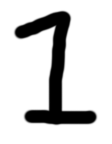

In [23]:
onj[0]